# Rekomendasi Movie
*oleh: Ridho Agung Prasetyo*

link kaggle : https://www.kaggle.com/datasets/sayan0211/movie-recomendation-pjct

# Mengimpor Library

Pada tahap ini, perlu kita mengimpor library yanng dibutuhkan untuk menyelesaikan proyek

In [1]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default = 'colab'
from wordcloud import WordCloud,STOPWORDS

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Data Loading

Melihat 5 baris pertama dari data dengan .head() dan ukuran dari data dengan .shape

In [2]:
movies_data = pd.read_csv('movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Menampilkan jummlah baris dan kolom pada data
total_row, total_column = movies_data.shape
print(f"Total of rows: {total_row}")
print(f"Total of column: {total_column}")

Total of rows: 9742
Total of column: 3


Berikut adalah arti dari variabel-variabel pada data tersebut.

Variabel | Keterangan
----------|----------
movieId | ID movie
title | Judul movie
genres | Genre dari movie

Memeriksa Tipe Variabel beserta jumlahnya

In [4]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Dari hasil di atas, terdapat:
*   1 kolom bertipe interger
*   2 kolom bertipe object

Selain itu juga terlihat tidak ada kolom yang mempunyai nilai null. hal ini bisa dibuktikan nanti saat masuk proses Data Cleaning.


In [5]:
movies_data.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


Dari Hasil diatas beberapa yang bisa disimpukan:

1.   Distribusi Tidak Merata: Data movieId memiliki rentang nilai yang sangat luas (dari 1 hingga 193.609) dengan banyak nilai yang terkonsentrasi di bagian bawah distribusi (berdasarkan Q1 dan median yang kecil dibandingkan Q3 dan max).

2.   Kemungkinan Data Skewed: Dengan nilai rata-rata lebih besar dari median, distribusi data kemungkinan memiliki kemiringan positif (skewed to the right).


3.   Tidak Representatif untuk Analisis Kuantitatif: Karena movieId hanyalah identifier, analisis ini lebih memberikan wawasan tentang cakupan dataset (berapa banyak film yang ada dan bagaimana data ini tersebar).

In [6]:
print('Jumlah data genre: ', len(movies_data.genres.unique()))

Jumlah data genre:  951


Melihat jumlah Genre terdapat 951 data

# Data Cleaning

In [7]:
# Menghitung jumlah data kosong pada setiap kolom
movies_data.isnull().sum()

,0
movieId,0
title,0
genres,0


Terlihat bahwa tidak terdapat kolom dengan nilai kosong

## Memeriksa Data Duplikat

In [8]:
movies_data.duplicated().sum()

0

Terlihat tidak ada duplikat data

# Exploratory Data Analysis (EDA)

## Memuat Dataset ke dalam variabel baru

In [9]:
# Memuat dataset ke dalam variable baru
movie = movies_data.movieId.unique()

# Mengurutkan data dan menghapus data yang sama
movie = np.sort(np.unique(movie))

print('Jumlah seluruh data movie berdasarkan movieId: ', len(movie))

Jumlah seluruh data movie berdasarkan movieId:  9742


In [10]:
movie_info = pd.concat([movies_data])

movie_info

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
# Melihat beberapa contoh genre
print(movies_data['genres'].head(10))

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
5                          Action|Crime|Thriller
6                                 Comedy|Romance
7                             Adventure|Children
8                                         Action
9                      Action|Adventure|Thriller
Name: genres, dtype: object


In [12]:
# Menghitung jumlah genre unik
genre_counts = movies_data['genres'].value_counts()
print("\nJumlah setiap genre:\n", genre_counts)


Jumlah setiap genre:
 genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64


In [13]:
# 1. Genre paling populer
print("\nGenre paling populer:", genre_counts.index[0])


Genre paling populer: Drama


In [14]:
# 2. Genre yang paling jarang
print("\nGenre paling jarang:", genre_counts.index[-1])


Genre paling jarang: Action|Animation|Comedy|Fantasy


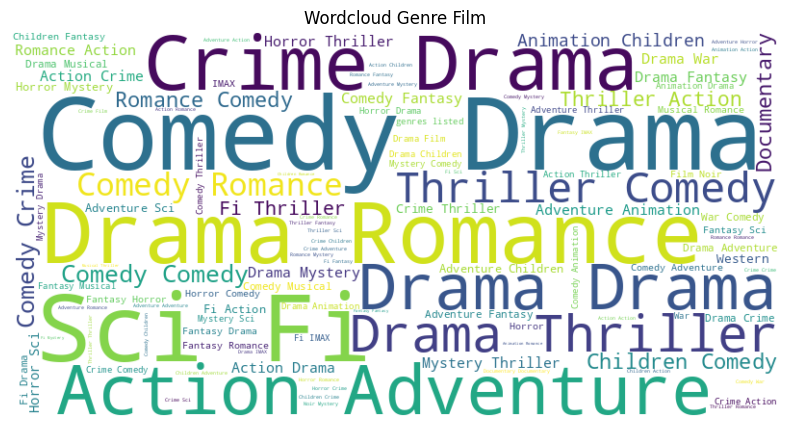

In [15]:
# 3.  Membuat wordcloud untuk visualisasi genre
text = ' '.join(movies_data['genres'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Genre Film')
plt.show()

In [16]:
# 4. Eksplorasi genre kombinasi
genre_combinations = movies_data['genres'].str.split('|').explode()
genre_combination_counts = genre_combinations.value_counts()

print("Genre Combinations and their counts:\n", genre_combination_counts)

Genre Combinations and their counts:
 genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


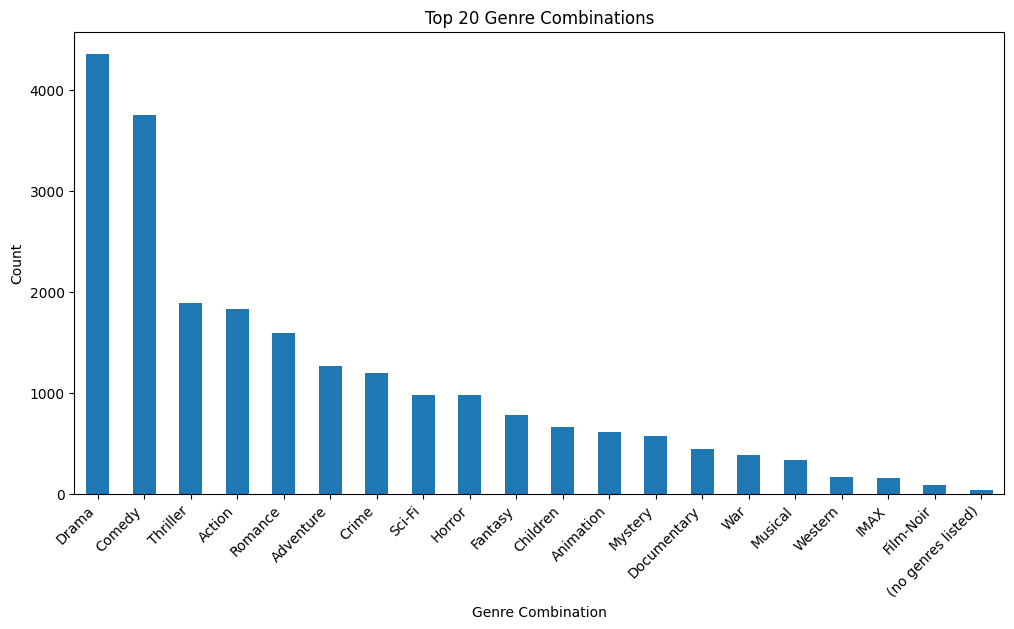

In [17]:
# Visualisasi genre kombinasi (contoh menggunakan bar chart)
plt.figure(figsize=(12, 6))
genre_combination_counts.head(20).plot(kind='bar')  # Menampilkan 20 genre kombinasi teratas
plt.title('Top 20 Genre Combinations')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Analisis Distribusi kolom numerikal dengan histogram

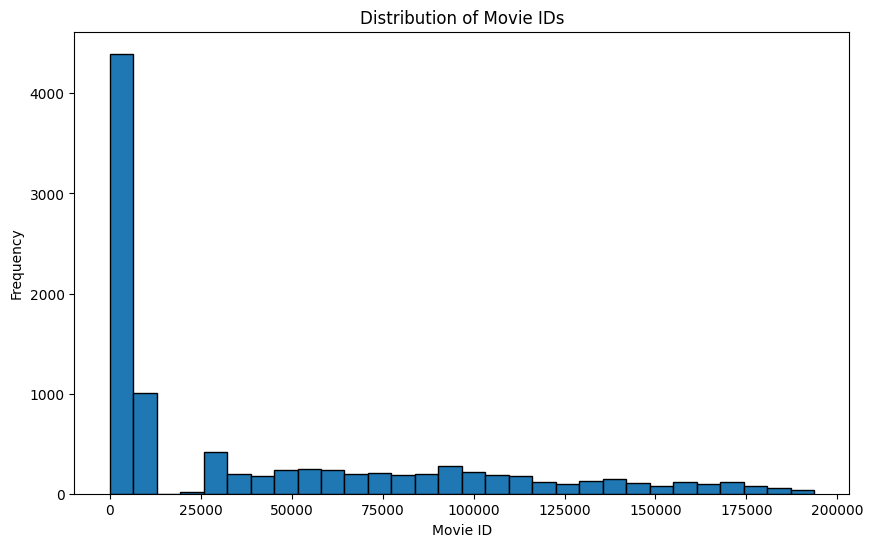

In [18]:
# menganalisis distribusi kolom numerik (movieId)
plt.figure(figsize=(10, 6))
plt.hist(movies_data['movieId'], bins=30, edgecolor='black')  # bins menyesuaikan jumlah kelompok
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.title('Distribution of Movie IDs')
plt.show()

## Memilih kolom berdasarkan data yang dibutuhkan untuk  melakukan content based learning berdasarkan genre

In [19]:
judul_movie = movies_data['title'].tolist()
genre_movie = movies_data['genres'].tolist()

print(len(judul_movie))
print(len(genre_movie))

9742
9742


Membuat data menjadi dalam bentuk dataframe sehingga mudah untuk dipersiapkan

In [20]:
data = pd.DataFrame({
    'judul': judul_movie,
    'genre': genre_movie
})

data

,judul,genre
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,Flint (2017),Drama
9740,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [21]:
# Memuat banyak data dari setiap uniqe value berdasarkan genre
value_genre = pd.DataFrame(data['genre'].value_counts().reset_index().values, columns = ['genre', 'count'])
print(len(value_genre))
pd.options.display.max_colwidth = 500
value_genre

951


,genre,count
0,Drama,1053
1,Comedy,946
2,Comedy|Drama,435
3,Comedy|Romance,363
4,Drama|Romance,349
...,...,...
946,Action|Crime|Horror|Mystery|Thriller,1
947,Adventure|Animation|Children|Comedy|Musical|Romance,1
948,Action|Adventure|Animation|Comedy|Crime|Mystery,1
949,Children|Comedy|Fantasy|Sci-Fi,1


In [22]:
data.genre.unique()

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Adventure|Drama', 'Drama|Thriller',
       'Comedy|Crime', 'Action|Sci-Fi|Thriller',
       'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentary',
       'Ac

In [23]:
data.reset_index()
data

,judul,genre
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,Flint (2017),Drama
9740,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [24]:
# Memasukkan nilai data masing masing kolom kedalam variabel baru
judul = data['judul'].tolist()
genre = data['genre'].tolist()

print(len(judul))
print(len(genre))

9742
9742


In [25]:
# mengecek ulang data yg dimasukkan ke dalam variable baru
data = pd.DataFrame({
    'judul': judul,
    'genre': genre
})
data

,judul,genre
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,Flint (2017),Drama
9740,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Membangun sistem rekomendasi berdasarkan genre

In [26]:
# Inisialisasi CountVectorizer
tf = CountVectorizer()

# Melakukan perhitungan idf pada data genre
tf.fit(genre)

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [27]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(genre)

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9742, 24)

In [28]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Melihat daftar jumlah film berdasarkan genre dan melihat korelasi yang diperliahtkan dalam bentuk matrix

In [29]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.judul
).sample(22, axis=1).sample(10, axis=0)

,action,animation,sci,no,noir,comedy,western,children,imax,fi,...,mystery,fantasy,genres,film,crime,horror,musical,romance,documentary,adventure
judul,,,,,,,,,,,,,,,,,,,,,
I Love You to Death (1990),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Watch Out for the Automobile (Beregis avtomobilya) (1966),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
Wonder (2017),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Must Love Dogs (2005),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
"Thrill of It All, The (1963)",0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Muppets Take Manhattan, The (1984)",0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
I Spit on Your Grave (Day of the Woman) (1978),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Battle Planet (2008),1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
The Last Witch Hunter (2015),1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# Modeling

melatih model dengan cosine similarity

In [30]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

Menampilkan matriks kesamaan setiap judul dengan menampilkan judul film dalam 10 sampel kolom (axis = 1) dan 10 sampel baris (axis = 0).

In [31]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['judul'], columns=genre)
print('Shape:', cosine_sim_df.shape)


cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (9742, 9742)


,Drama,Comedy|Drama,Comedy,Comedy,Adventure|Drama,Drama|Romance,Children|Comedy|Musical|Romance,Drama|War,Crime|Mystery,Action|Adventure|Sci-Fi
judul,,,,,,,,,,
Ponyo (Gake no ue no Ponyo) (2008),0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.250000,0.000000,0.000000,0.250000
Gunner Palace (2004),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
The Second Best Exotic Marigold Hotel (2015),0.707107,1.000000,0.707107,0.707107,0.500000,0.500000,0.353553,0.500000,0.000000,0.000000
Reservoir Dogs (1992),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000
My Dog Skip (1999),0.707107,0.500000,0.000000,0.000000,0.500000,0.500000,0.353553,0.500000,0.000000,0.000000
"Bear, The (Ours, L') (1988)",0.577350,0.408248,0.000000,0.000000,0.816497,0.408248,0.288675,0.408248,0.000000,0.288675
Town & Country (2001),0.000000,0.707107,1.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
Land Before Time III: The Time of the Great Giving (1995),0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.500000,0.000000,0.000000,0.250000
Boogeyman (2005),0.500000,0.353553,0.000000,0.000000,0.353553,0.353553,0.000000,0.353553,0.353553,0.000000


# Evaluasi Model

In [35]:
indices = pd.Series(index = data['judul'], data = data.index).drop_duplicates()
indices.head()

,0
judul,
Toy Story (1995),0
Jumanji (1995),1
Grumpier Old Men (1995),2
Waiting to Exhale (1995),3
Father of the Bride Part II (1995),4


Membuat fungsi untuk memanggil 10 rekomendasi film berdasarkan judul yang di input

In [41]:
def movie_recommendations(judul, cosine_sim = cosine_sim,items=data[['judul','genre']]):
    # Mengambil indeks dari judul film yang telah didefinisikan sebelumnnya
    idx = indices[judul]

    # Mengambil skor kemiripan dengan semua judul film
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan film berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)

    # Mengambil 10 skor kemiripan dari 1-11 karena urutan 0 memberikan indeks yang sama dengan judul film yang diinput
    sim_scores = sim_scores[1:11]

    # Mengambil judul film dari skor kemiripan
    movie_indices = [i[0] for i in sim_scores]

    # Mengembalikan 20 rekomendasi judul film dari kemiripan skor yang telah diurutkan dan menampilkan genre dari 20 rekomendasi film tersebut
    return pd.DataFrame(data['judul'][movie_indices]).merge(items)

In [46]:
# mengecek judul film di dalam data
data[data.judul.eq('Jeffrey (1995)')]

,judul,genre
143,Jeffrey (1995),Comedy|Drama


Mencoba menampilkan 10 rekomendasi film dari judul yang telah diinput menggunakan fungsi movie_recomendations

In [50]:
recomendation = pd.DataFrame(movie_recommendations('Jeffrey (1995)'))
recomendation

,judul,genre
0,Big Bully (1996),Comedy|Drama
1,Antonia's Line (Antonia) (1995),Comedy|Drama
2,In the Bleak Midwinter (1995),Comedy|Drama
3,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama
4,Blue in the Face (1995),Comedy|Drama
5,Jeffrey (1995),Comedy|Drama
6,Love & Human Remains (1993),Comedy|Drama
7,Smoke (1995),Comedy|Drama
8,Unstrung Heroes (1995),Comedy|Drama
9,Boys on the Side (1995),Comedy|Drama


In [51]:
# menghitung banyaknya data genre pada hasil rekomendasi yg dilakukan
value = pd.DataFrame(recomendation['genre'].value_counts().reset_index().values, columns = ['genre', 'count'])
value.head()

,genre,count
0,Comedy|Drama,10


Melakukan perhitungan dengan menggunakan metrik precision untuk melihat akurassi

In [52]:
TP = 9 #jumlah prediksi benar untuk genre yang mirip atau serupa
FP = 0 #jumlah prediksi salah untuk genre yang mirip atau serupa

Precision = TP/(TP+FP)
print("{0:.0%}".format(Precision))

100%
